# 🏦 **Bank Customer Complaint Classification** 🏦
---
## 📖 Capstone Summary
---

### 💣 Problem Statement
> Banks often receive a multitude of customer complaints. Due to the sheer volume, bank customer service teams frequently struggle to categorize these complaints accurately. Consequently, **the complaint resolution process slows down, leading to customer dissatisfaction**.

### 🤖 NLP Implementation
> o address this issue, we can employ Natural Language Processing (NLP) technology. With **NLP, we can create a system that automatically recognizes the content of customer complaints and determines the appropriate product category**. This will make the complaint handling process faster and more efficient.


### 🎯 Target
> The goal of using this NLP system is to **speed up the response time** of the customer service team and **improve the accuracy** in classifying complaints. The target is to create an NLP system with an **accuracy rate of at least 80%**, measured by metrics such as Accuracy, Precision, Recall, and F1-Score.

With this system, banks are expected to respond to customer complaints more quickly and accurately, thereby increasing customer satisfaction and the efficiency of the customer service team. I hope this explanation helps you convey your project more clearly to the readers.

# 📚Import Library

In [1]:
# Data Loading & Cleaning
import re
import nltk
import string
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# NLTK Dataset
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize

# Visulalize Data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
from wordcloud import WordCloud

# Evaluation Matrics & Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Modeling
import tensorflow as tf
import tensorflow_hub as tf_hub
from tf_keras.models import Sequential, load_model
from tf_keras.utils import to_categorical
from tf_keras.layers import TextVectorization, Embedding, Dense, LSTM, Dropout, BatchNormalization
from tf_keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from tf_keras.metrics import Precision, Recall, AUC

# NLTK-Dataset Update
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     f:\IPB\MSIB\Tugas\Capstone\Streamlit\venv\lib\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     f:\IPB\MSIB\Tugas\Capstone\Streamlit\venv\lib\nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     f:\IPB\MSIB\Tugas\Capstone\Streamlit\venv\lib\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     f:\IPB\MSIB\Tugas\Capstone\Streamlit\venv\lib\nltk_dat
[nltk_data]     a...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# 📂 Data Loading & Cleaning

## Data Load

In [4]:
data = pd.read_csv("complaints.csv", index_col=0)
data.head()

product                                          narrative
0       credit_card  purchase order day shipping amount receive pro...
1       credit_card  forwarded message date tue subject please inve...
2    retail_banking  forwarded message cc sent friday pdt subject f...
3  credit_reporting  payment history missing credit report speciali...
4  credit_reporting  payment history missing credit report made mis...

## Rename Columns
- product ▶ **label** 
- narrative ▶ **complaints**

In [5]:
data.columns = ['label','complaints']
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162421 entries, 0 to 162420
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   label       162421 non-null  object
 1   complaints  162411 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


## Label Grouping
- Credit Card
- Credit Reporting
- Debt Collection
- Mortgages and Loans
- Retail Banking

In [6]:
data.groupby('label').describe()

complaints         \
                         count unique   
label                                   
credit_card              15566  15024   
credit_reporting         91172  56303   
debt_collection          23148  21117   
mortgages_and_loans      18990  18759   
retail_banking           13535  13473   

                                                                             
                                                                   top freq  
label                                                                        
credit_card          see multiple day late mark clear violation rig...  130  
credit_reporting     victim identity notified collection creditor s...  739  
debt_collection      disputed account reached many time failed acco...  167  
mortgages_and_loans  see multiple day late mark clear violation rig...   83  
retail_banking       paypal negative transfer loading transaction d...    8

## Null Data
The process of checking for empty or Null data was conducted. It was found that there are **10 Null complaints messages**. Since the null data is present in the complaints messages and not in the message labels, the **records containing this data will be deleted**.

In [7]:
data.isnull().sum()

label          0
complaints    10
dtype: int64

### View Null Data

In [8]:
data_complaints = data[data['complaints'].isnull()]
print(data_complaints)

                   label complaints
1089    credit_reporting        NaN
3954    credit_reporting        NaN
3955    credit_reporting        NaN
29690   credit_reporting        NaN
139436   debt_collection        NaN
151052   debt_collection        NaN
154494  credit_reporting        NaN
156902    retail_banking        NaN
158538  credit_reporting        NaN
159503  credit_reporting        NaN


### Drop Null Data

In [9]:
data.dropna(how="any", axis=0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162411 entries, 0 to 162420
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   label       162411 non-null  object
 1   complaints  162411 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


## Duplicated Data
A process was undertaken to check for duplicate complaints messages within the data model. It was discovered that there are **37,735 complaints messages that are duplicates**. Some messages were duplicated as many as **739 and 415 times**. The presence of such a large number of duplicate messages could lead to bias in the model, therefore, **all duplicate messages will be removed**.

In [10]:
data.groupby(data.duplicated(), as_index=False).size()

index    size
0  False  124676
1   True   37735

### View Duplicated Data

In [11]:
data_duplicated = data[data.duplicated(subset='complaints', keep=False)]
data_duplicated['frequency'] = data_duplicated.groupby('complaints')['complaints'].transform('count')
data_duplicated.drop_duplicates(subset='complaints', keep='first', inplace=True)
data_duplicated.sort_values(by='frequency', ascending=False)

label                                         complaints  \
28837  credit_reporting  victim identity notified collection creditor s...   
3217   credit_reporting  account added created unbeknownst notice conce...   
521    credit_reporting  filed dispute regard incorrect item credit rep...   
28124  credit_reporting  victim identity theft due corona virus pandemi...   
27356  credit_reporting                              victim identity theft   
...                 ...                                                ...   
574    credit_reporting  keep closing request investigation credit prof...   
599    credit_reporting  governor name reporting error information exis...   
627    credit_reporting  recent credit report currently reporting appli...   
643    credit_reporting  writing due failed remove information affiliat...   
666    credit_reporting  pulled credit alerted social security card get...   

       frequency  
28837        739  
3217         415  
521          338  
28124        306  
27356        271  
...          ...  
574            2  
599            2  
627            2  
643            2  
666            2  

[12281 rows x 3 columns]

### Drop Duplicated Data

In [12]:
data.drop_duplicates(subset='complaints', keep='first', inplace=True)
data.groupby(data.duplicated(), as_index=False).size()

index    size
0  False  124472

## Clean Text
The text cleaning process for the complaints messages is carried out to facilitate easier model training. The clean text process includes:

### Normalize
---

 The process of converting all text to lowercase, removing punctuation, and eliminating extra spaces.

In [13]:
def normalize_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

In [14]:
data['complaints_clean'] = data['complaints'].apply(normalize_text)
data.head()

label                                         complaints  \
0       credit_card  purchase order day shipping amount receive pro...   
1       credit_card  forwarded message date tue subject please inve...   
2    retail_banking  forwarded message cc sent friday pdt subject f...   
3  credit_reporting  payment history missing credit report speciali...   
4  credit_reporting  payment history missing credit report made mis...   

                                    complaints_clean  
0  purchase order day shipping amount receive pro...  
1  forwarded message date tue subject please inve...  
2  forwarded message cc sent friday pdt subject f...  
3  payment history missing credit report speciali...  
4  payment history missing credit report made mis...

### Stopwords
---

The process of removing words that are commonly used in a language and do not add significant meaning to the text.

In [15]:
stop_words = stopwords.words('english')

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [16]:
data['complaints_clean'] = data['complaints_clean'].apply(remove_stopwords)
data.head()

label                                         complaints  \
0       credit_card  purchase order day shipping amount receive pro...   
1       credit_card  forwarded message date tue subject please inve...   
2    retail_banking  forwarded message cc sent friday pdt subject f...   
3  credit_reporting  payment history missing credit report speciali...   
4  credit_reporting  payment history missing credit report made mis...   

                                    complaints_clean  
0  purchase order day shipping amount receive pro...  
1  forwarded message date tue subject please inve...  
2  forwarded message cc sent friday pdt subject f...  
3  payment history missing credit report speciali...  
4  payment history missing credit report made mis...

### Lemmatize
---

The process of converting words to their base form.

In [17]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    word_pos_tags = pos_tag(word_tokenize(text)) # Tokenize dan tag pos
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in word_pos_tags]

    return ' '.join(lemmatized_words)

In [18]:
data['complaints_clean'] = data['complaints_clean'].apply(lemmatize_text)
data.head()

label                                         complaints  \
0       credit_card  purchase order day shipping amount receive pro...   
1       credit_card  forwarded message date tue subject please inve...   
2    retail_banking  forwarded message cc sent friday pdt subject f...   
3  credit_reporting  payment history missing credit report speciali...   
4  credit_reporting  payment history missing credit report made mis...   

                                    complaints_clean  
0  purchase order day ship amount receive product...  
1  forward message date tue subject please invest...  
2  forward message cc send friday pdt subject fin...  
3  payment history miss credit report specialize ...  
4  payment history miss credit report make mistak...

## Add Num Label and Length Complaints
Added a column named **label_num** to create a numerical representation for each product complaint label. Also, a column named **complaints_len** was created to count the number of words in each received complaint message to be *analyzed as the output sequence length value in vectorization*

In [19]:
data['label_num'] = data.label.map({
                                    'credit_card':0,
                                    'credit_reporting':1,
                                    'debt_collection':2,
                                    'mortgages_and_loans':3,
                                    'retail_banking':4
                                    })
data['complaints_len'] = data['complaints_clean'].apply(lambda x: len(x.split(' ')))

data.sort_values(by='complaints_len', ascending=False).head()

label  \
119476  mortgages_and_loans   
7272       credit_reporting   
137348  mortgages_and_loans   
9773            credit_card   
122518  mortgages_and_loans   

                                               complaints  \
119476  please refer full detail written within page p...   
7272    public service staff federal trade commission ...   
137348  complaint involves est mile time purchase incl...   
9773    brink money netspend account application suppo...   
122518  request deficiency review denial entitlement s...   

                                         complaints_clean  label_num  \
119476  please refer full detail write within page pdf...          3   
7272    public service staff federal trade commission ...          1   
137348  complaint involve est mile time purchase inclu...          3   
9773    brink money netspend account application suppo...          0   
122518  request deficiency review denial entitlement s...          3   

        complaints_len  
119476            2684  
7272              2568  
137348            2526  
9773              2412  
122518            2339

## Define New Order Column

In [20]:
# Define the new column order
new_order = ['label', 'label_num', 'complaints', 'complaints_clean', 'complaints_len']
data = data.reindex(columns=new_order)
data.sort_values(by='complaints_len', ascending=False).head()

label  label_num  \
119476  mortgages_and_loans          3   
7272       credit_reporting          1   
137348  mortgages_and_loans          3   
9773            credit_card          0   
122518  mortgages_and_loans          3   

                                               complaints  \
119476  please refer full detail written within page p...   
7272    public service staff federal trade commission ...   
137348  complaint involves est mile time purchase incl...   
9773    brink money netspend account application suppo...   
122518  request deficiency review denial entitlement s...   

                                         complaints_clean  complaints_len  
119476  please refer full detail write within page pdf...            2684  
7272    public service staff federal trade commission ...            2568  
137348  complaint involve est mile time purchase inclu...            2526  
9773    brink money netspend account application suppo...            2412  
122518  request deficiency review denial entitlement s...            2339

# 📊 Exploratory Data Analysis (EDA)

## Distribution Data
---

- The data distribution process tends to **result in imbalanced data**
- The distribution of *Credit Reporting is more dominant* compared to other data distributions
- A data resampling process is **necessary to achieve a balanced distribution**
> The resampling process can be performed using `Oversampling SMOTE` or `Undersampling RUS methods`

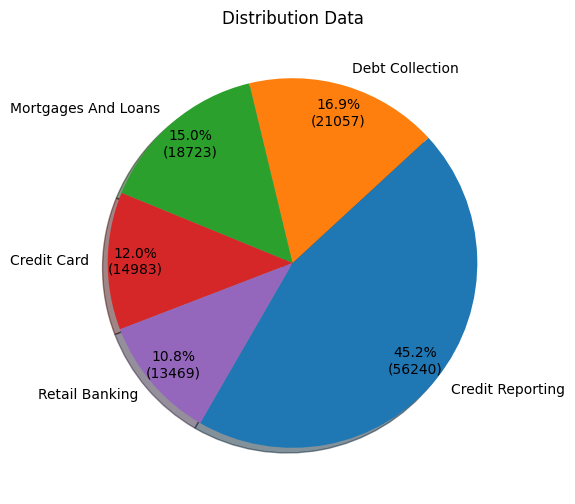

In [21]:
count_data = data['label'].value_counts()
labels = count_data.index.tolist()
index = count_data.values.tolist()

labels = [label.replace('_', ' ').title() for label in labels]

fig, ax = plt.subplots(figsize=(8,6))
ax.pie(index, labels=labels,
       autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p,(p/100)*sum(index)),
       pctdistance=0.85, shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9},
       startangle=-120)

plt.title('Distribution Data')
plt.show()

## Complaints Length
---

- The frequency of word length in each complaint message varies greatly, with some messages containing up to `2684 words`.
- On average, a complaint message contains `87 words`.
- The standard deviation of the number of words in a complaint message is `110 words`.

Although the *majority of incoming complaint messages are 87 words long*, this number **cannot be used as a reference point because the maximum length observed in the data is 2684 words**.
> Based on visual analysis, 300 will be set as the limit for the frequency length of complaint messages.

In [22]:
colors = ['red','purple','blue','green','orange']

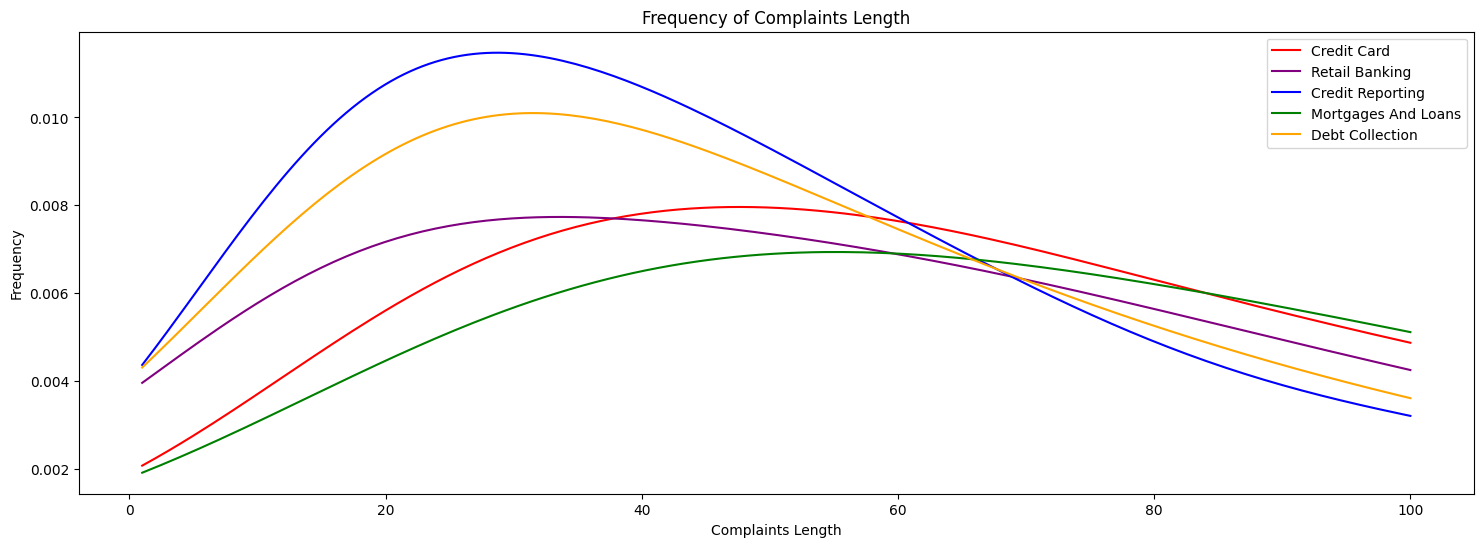

In [23]:
labels = data["label"].unique()
minimum_length = data["complaints_len"].max()

plt.figure(figsize=(18, 6))
for i, label in enumerate(labels):
  complaints_len = data[data["label"] == label].complaints_len
  sns.kdeplot(complaints_len, clip=(1,100), label=label.replace('_', ' ').title(), color=colors[i])
plt.title('Frequency of Complaints Length')
plt.ylabel('Frequency')
plt.xlabel('Complaints Length')
plt.legend()
plt.show()

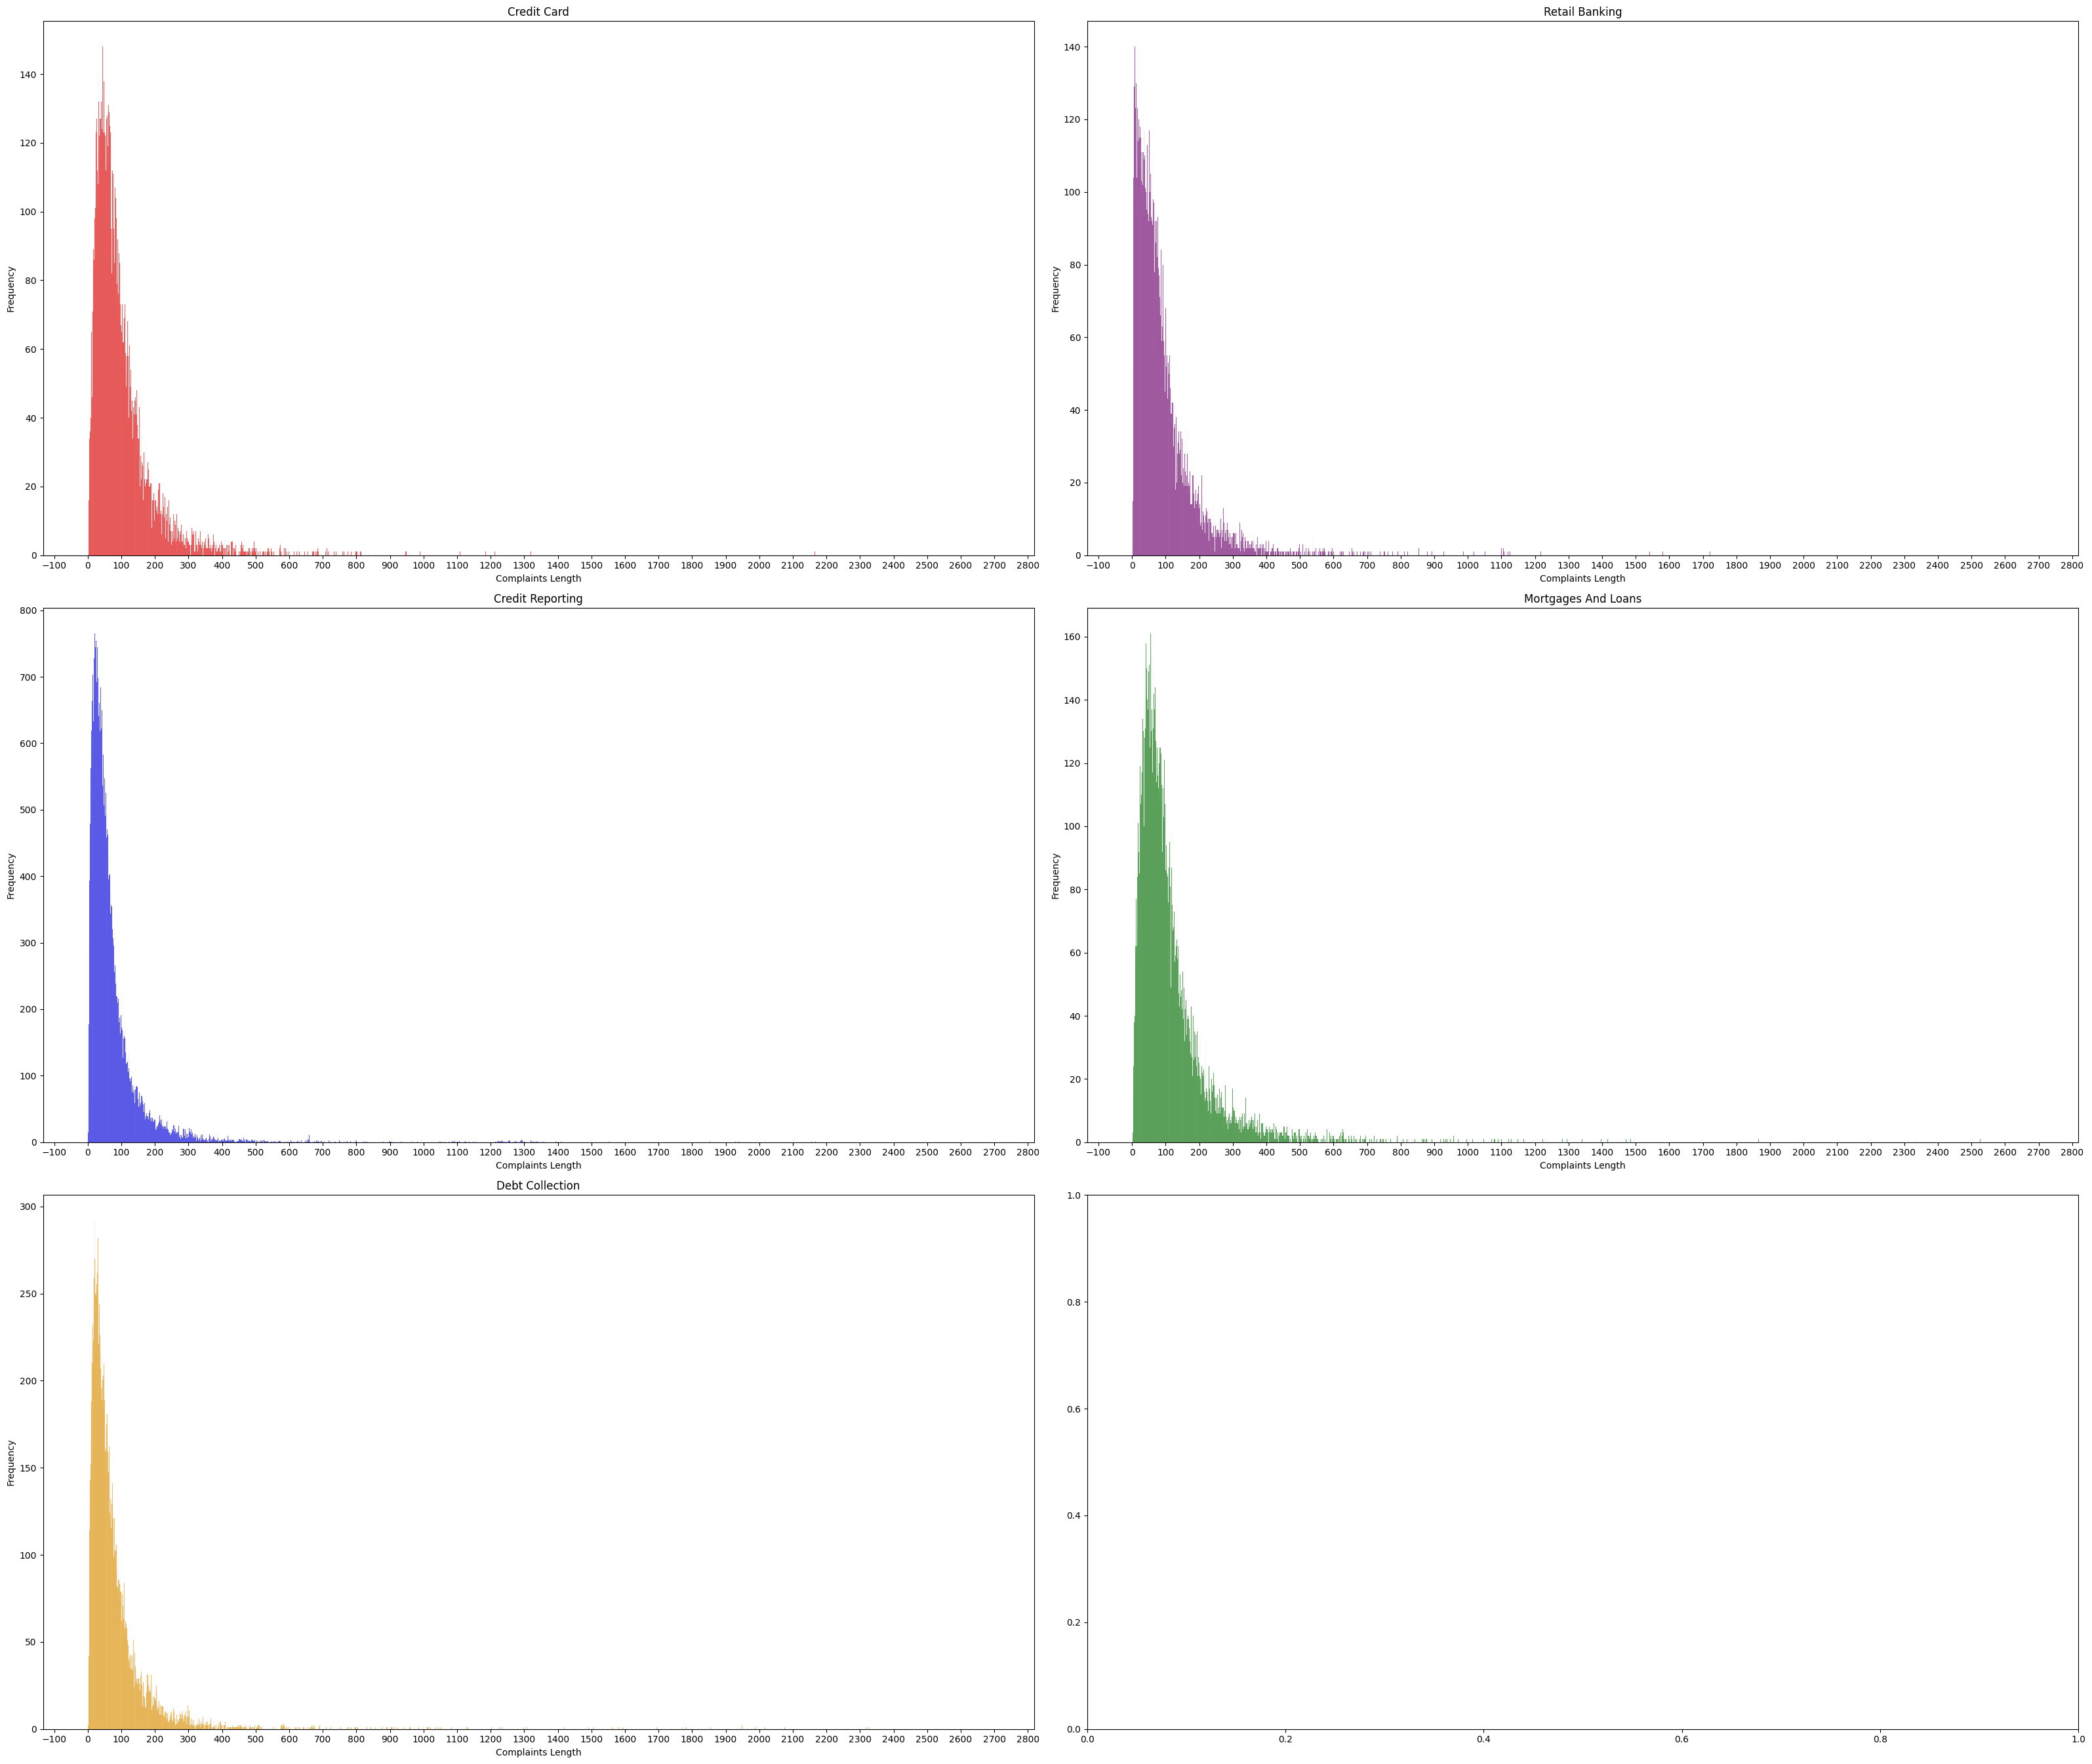

In [24]:
labels = data['label'].unique()
colors = ['red','purple','blue','green','orange']
n = len(labels)

ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(16*ncols, 9*nrows))

max_complaints_len = data['complaints_len'].max()

for i, label in enumerate(labels):
    row = i // ncols
    col = i % ncols
    complaints_len = data[data['label']==label]['complaints_len']
    sns.histplot(complaints_len, bins=range(1, max_complaints_len + 1), ax=axs[row, col], alpha=0.6, color=colors[i])
    axs[row, col].xaxis.set_major_locator(ticker.MultipleLocator(100))
    axs[row, col].set_title(label.replace('_', ' ').title())
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].set_xlabel('Complaints Length')

plt.tight_layout()
plt.show()

In [25]:
data['complaints_len'].describe()

count    124472.000000
mean         87.147503
std         110.904784
min           1.000000
25%          30.000000
50%          58.000000
75%         104.000000
max        2684.000000
Name: complaints_len, dtype: float64

## Word Count
---

- Displays the 50 most frequently occurring words, with **account**, **credit**, **report**, **payment**, and **information** being the most common words in complaint messages.
- The total number of different or unique words appearing in a complaint message is **43,637 unique words**.
- The average frequency of each word appearing is 248 times.

With 43,637 unique words, not all of these can be used as tokens in the model, considering the average frequency of each word’s occurrence is only 248 times.
> The number of word tokens used in the NLP Model is those whose frequency of occurrence is above average, which is **2,650 tokens** used in the NLP Model.

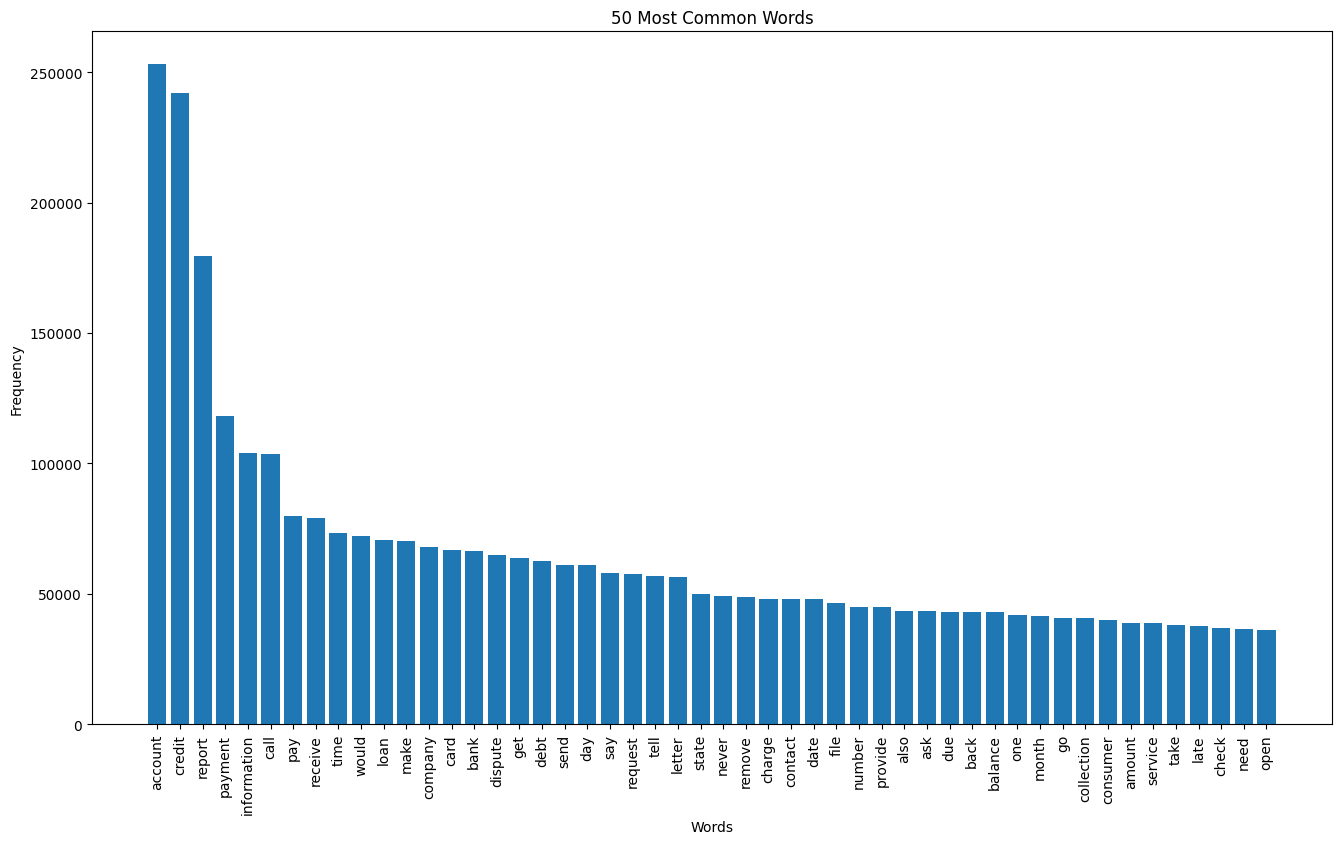

In [26]:
# Flatten the list of tokens and count the frequency of each token
tokens = data['complaints_clean'].apply(lambda x: x.split(' '))
all_words = [word for tokens in tokens for word in tokens]
word_freq = Counter(all_words)

# Get the 25 most common words
common_words = word_freq.most_common(50)

# Unzip the words and their counts
words, counts = zip(*common_words)

# Create a bar plot
plt.figure(figsize=(16,9))
plt.bar(words, counts)
plt.title('50 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [27]:
# Counting the number of unique words
unique_words = set(all_words)
unique_word_count = len(unique_words)

# Calculating the total frequency of each word's occurrence
total_freq = sum(word_freq.values())

# Calculating the average frequency of occurrence for each word
average_freq = total_freq / unique_word_count

# Counting how many unique words have a frequency above the average
above_average_words = [word for word, freq in word_freq.items() if freq > average_freq]
above_average_count = len(above_average_words)

print("Number of unique words:", unique_word_count)
print("Average frequency of each word's occurrence:", average_freq)
print("Number of unique words above average frequency:", above_average_count)


Number of unique words: 43637
Average frequency of each word's occurrence: 248.5831748287004
Number of unique words above average frequency: 2651


## Word Cloud
---

- There are several words that frequently appear across various product labels in the received complaint messages, such as `ca, amex, u bank, im, u, citi, fcra section, equifax, usaa, boa`
> *It is necessary to conduct further checks on each of these words to determine whether they have an impact on the model or not.*

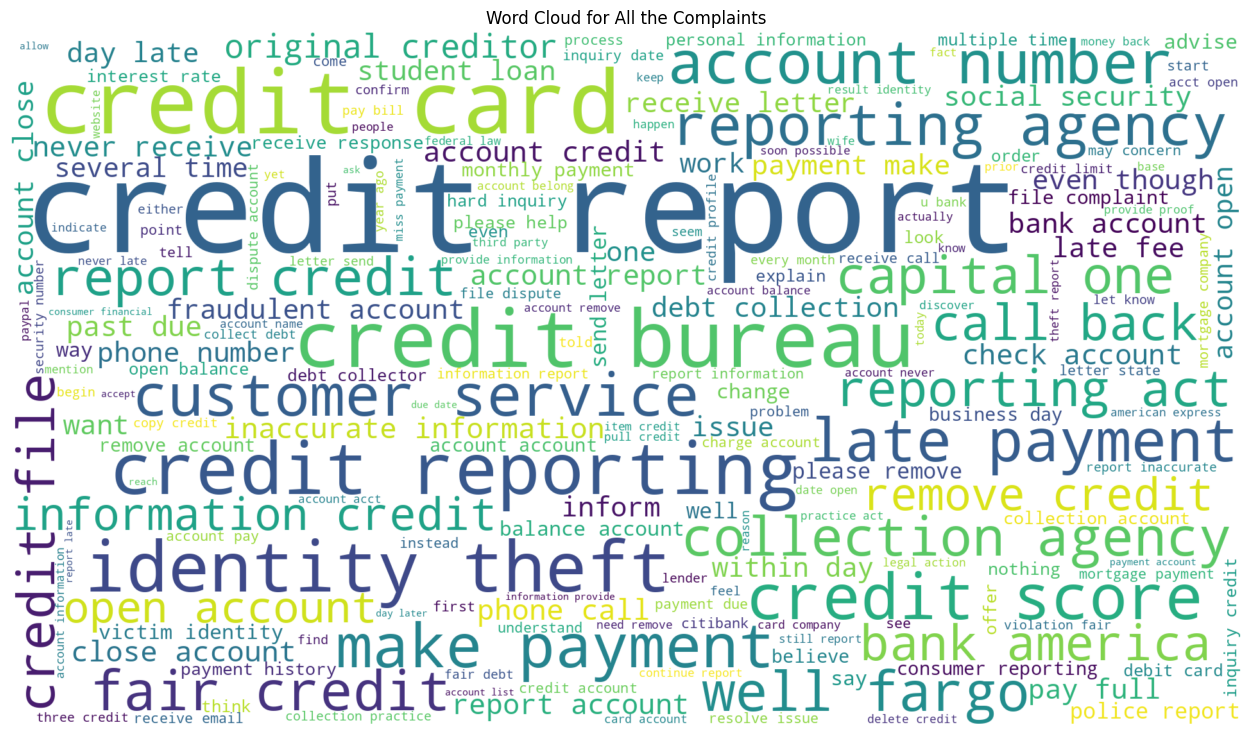

In [28]:
combine_text= ' '.join(data['complaints_clean'])
wordcloud_text= WordCloud(width=1920, height=1080, background_color='white').generate(combine_text)
plt.figure(figsize=(16,9))
plt.imshow(wordcloud_text, interpolation='bilinear')
plt.title(f"Word Cloud for All the Complaints")
plt.axis('off')
plt.show()

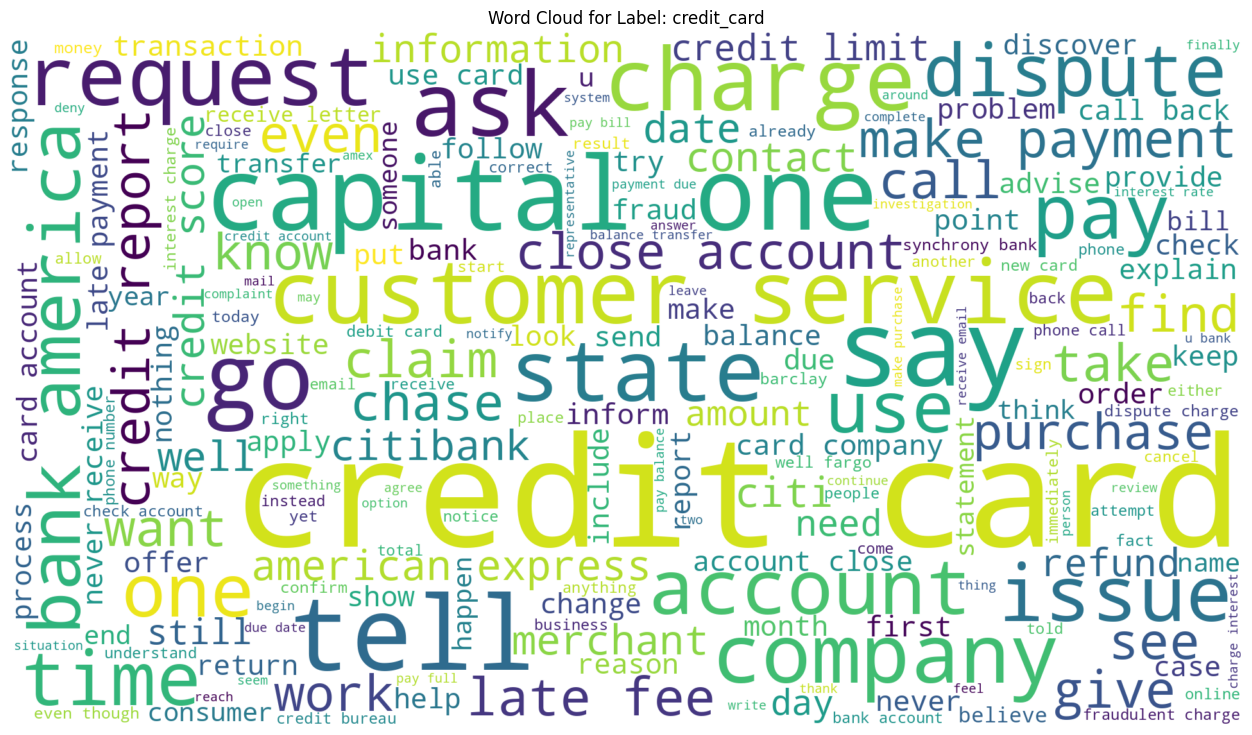

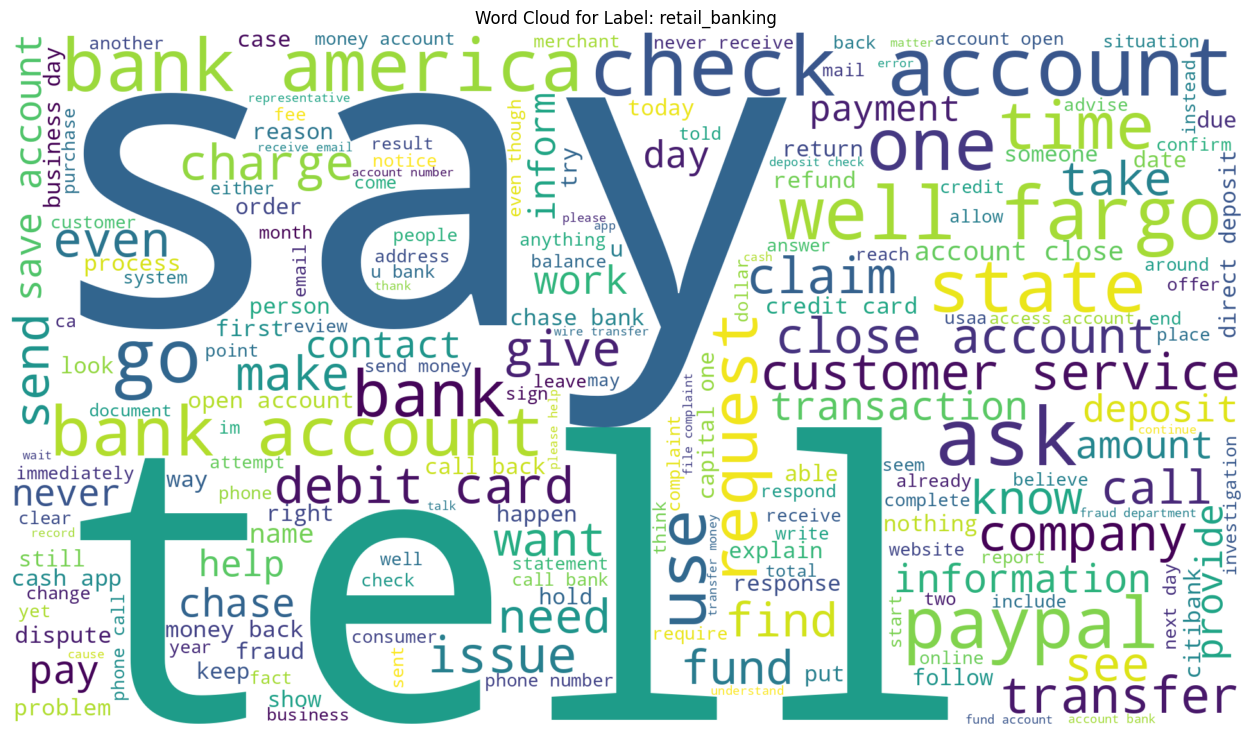

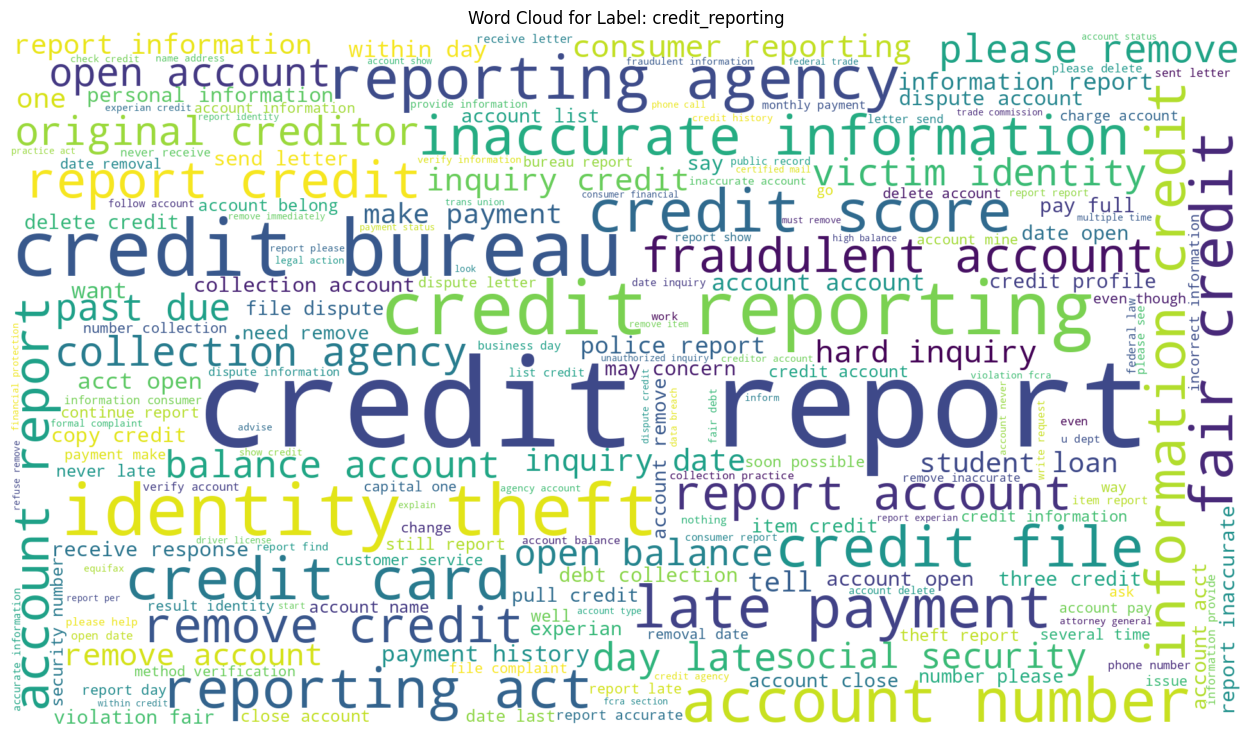

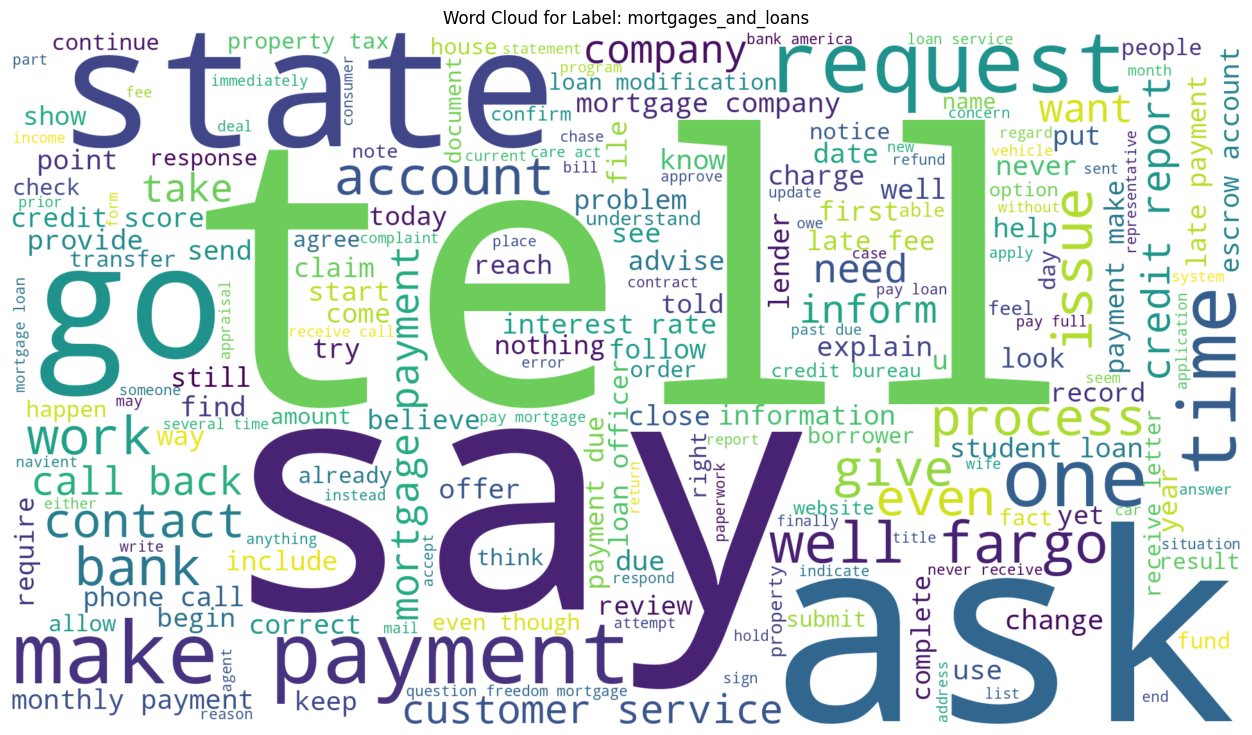

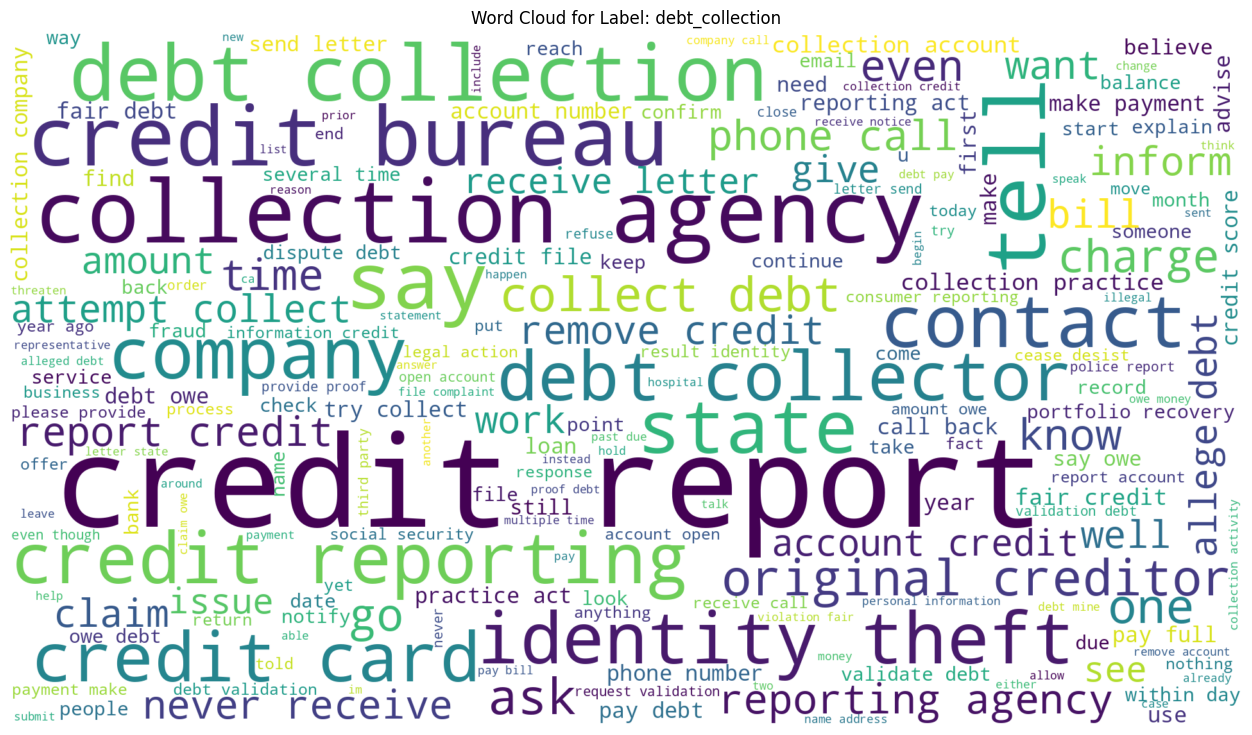

In [29]:
labels = data['label'].unique()
for label in labels:
    label_text = ' '.join(data[data['label'] == label]['complaints_clean'])
    wordcloud = WordCloud(width=1920, height=1080, background_color='white').generate(label_text)

    # Word cloud
    plt.figure(figsize=(16, 9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Label: {label}")
    plt.axis('off')
    plt.show()

## Check word
---

- Some words that frequently appear in the word cloud `[ca, amex, u bank, im, u, citi, fcra section, equifax, usaa, boa]` have significance in the received complaint messages. These words are abbreviations for financial policy institutions in America.
- Several complaint messages insert the text xxxx within the message to conceal identity or personal information.
> In data preprocessing, *a clean text process will be conducted again to remove the words u and im*. Additionally, character strings like xxxx that hide personal information will be *removed to prevent influencing the model*.

In [30]:
# List of words to check
words_to_check = ['ca', 'amex', 'u bank', 'im', 'u', 'citi', 'fcra section', 'equifax', 'usaa', 'boa']
data_ex = data.copy()

# Checking the frequency of words in the 'complaints_clean' column and displaying three example sentences
for word in words_to_check:
  data_ex['contains_' + word] = data_ex['complaints_clean'].str.contains(word, case=False, regex=False)
  print(f"Frequency of '{word}':", data_ex['contains_' + word].sum())
  # Displaying example sentences
  examples = data_ex[data_ex['contains_' + word]]['complaints_clean'].head(1).tolist()
  print(f"Example sentences for '{word}':")
  for example in examples:
    print(f"- {example}")

Frequency of 'ca': 86576
Example sentences for 'ca':
- purchase order day ship amount receive product week send followup email exact verbiage pay two day ship receive order company respond im sorry inform due unusually high order volume order ship several week stock since early due high demand although continuing take order guarantee receive order place due time mask order exact shipping date right however guarantee ship soon soon delivers product u get small shipment ship first come first serve basis appreciate patience fulfill order quickly recommend keep order lose place line cancel distributor stock moment prefer cancel please note ask via email cancel accordance cancellation policy agree checkout electronic inventory online request order cancel refund issue cancel order send verification order cancel refunded item particulate respirator refund subtotal shipping tax total usd visa end refund call dispute amount state nothing need submit address issue recharge item remove call back 

In [31]:
# Pattern to search for words with the letter 'x' more than 3 times
pattern = r'\b(\w*x\w*){3,}\b'

# Applying filter to the data using the pattern
data_ex = data[data['complaints_clean'].str.contains(pattern, case=False, regex=True)]

# Counting the number of words matching the pattern in each row
data_ex['count'] = data_ex['complaints_clean'].str.findall(pattern, flags=re.IGNORECASE).str.len()

# Displaying example sentences
examples = data_ex['complaints_clean'].sample(3).tolist()

# Displaying the total number of words matching the pattern in the entire dataset
total_count = data_ex['count'].sum()
print(f"Total number of words matching the pattern: {total_count}")
for example in examples:
  print(f"- {example}")

Total number of words matching the pattern: 13949
- xxxxxxxx ga request investigation unauthorized inquiry may concern check personal credit report acquire organization notice unauthorized inquiry make contact placed inquiry ask remove credit inquiry credit profile also ask cease illegal activity immediately date response office since send letter business day ago fail respond honor request therefore must request help resolve matter accordance fair credit reporting act request immediately initiate investigation inquiry credit report determine authorize inquiry investigation complete find allegation true please remove unauthorized inquiry credit report send update copy credit report address list find inquiry reference valid request please send full description procedure use investigation within business day completion investigation tx request investigation unauthorized inquiry may concern check personal credit report acquire organization notice unauthorized inquiry make contact placed in

# 🔖 Preprocessing

## Re-clean Text
---

The text cleaning process for the complaint messages is revisited following the results from the EDA. At this stage, all processes of text **normalization**, **stopwords**, and **lemmatization**/**stemming** are performed within a single function. Additionally, custom words are added to the stopwords to remove certain extra words from the word cloud and to delete the `xxxx characters` in the complaint messages that are used to conceal personal information.

### Custom Stopwords

In [32]:
custom_stopwords = ['u','im']
stop_words = stop_words + custom_stopwords
pattern = r'\b(\w*x\w*){3,}\b'

def remove_stopwords(text):
  text = ' '.join(word for word in text.split(' ') if word not in stop_words)

  pattern = r'\b(\w*x\w*){3,}\b'
  text = re.sub(pattern, '', text, flags=re.IGNORECASE)

  return text

### Function Clean Text

In [33]:
def clean_text(text):
  text = normalize_text(text)
  text = remove_stopwords(text)
  text = lemmatize_text(text)
  return text

In [34]:
data['complaints_clean'] = data['complaints_clean'].apply(clean_text)
data['complaints_len'] = data['complaints_clean'].apply(lambda x: len(x.split(' ')))

data.sort_values(by='complaints_len', ascending=False).head()

label  label_num  \
119476  mortgages_and_loans          3   
7272       credit_reporting          1   
137348  mortgages_and_loans          3   
122518  mortgages_and_loans          3   
12718   mortgages_and_loans          3   

                                               complaints  \
119476  please refer full detail written within page p...   
7272    public service staff federal trade commission ...   
137348  complaint involves est mile time purchase incl...   
122518  request deficiency review denial entitlement s...   
12718   complaint herein given loan borrower hereinaft...   

                                         complaints_clean  complaints_len  
119476  please refer full detail write within page pdf...            2674  
7272    public service staff federal trade commission ...            2562  
137348  complaint involve est mile time purchase inclu...            2523  
122518  request deficiency review denial entitlement s...            2338  
12718   complaint herein give loan borrower hereinafte...            2327

## Train Split Data
---

The model data is divided into **training data**, **validation data**, and **testing data**. The division process is as follows:
- 20% of the data is allocated for testing.
- 80% of the data is used for training and validation.
    - 10% of that 80% is used as validation data.
    - 90% of that 80% is used as training data

In [35]:
X = data['complaints_clean']
y = data['label_num']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                            test_size=0.2,
                                                            random_state=42,
                                                            stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.1,
                                                  random_state=42,
                                                  stratify=y_train_val)
print('Train Size : ', len(X_train))
print('Val Size   : ', len(X_val))
print('Test Size  : ', len(X_test))

Train Size :  89619
Val Size   :  9958
Test Size  :  24895


## Tokenize & Vectorize
---

The process of Tokenization and Vectorization of the training data is carried out with the maximum number of tokens based on the EDA results and the length of the output text received based on the analysis conducted in the EDA.
>The Tokenize and Vectorize processes are performed concurrently using the TensorFlow TextVectorization library, which contains both processes.

In [36]:
vectorizer = TextVectorization(
    max_tokens=2650,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None,
    output_mode="int",
    output_sequence_length=300)
vectorizer.adapt(X_train)

In [37]:
X_train_vectorized = vectorizer(X_train)
X_val_vectorized = vectorizer(X_val)
X_test_vectorized = vectorizer(X_test)

## Resampling Data
---

Redistribution of the amount of data to be used is performed using Oversampling and Undersampling methods. This is to compare the results of the resampling to determine which method is better for the model.

### Oversampling

In [38]:
# Initialize Synthetic Minority Oversampling Technique
smote = SMOTE(random_state=42)

# Apply smote to the training data
X_train_ros, y_train_ros = smote.fit_resample(X_train_vectorized, y_train)

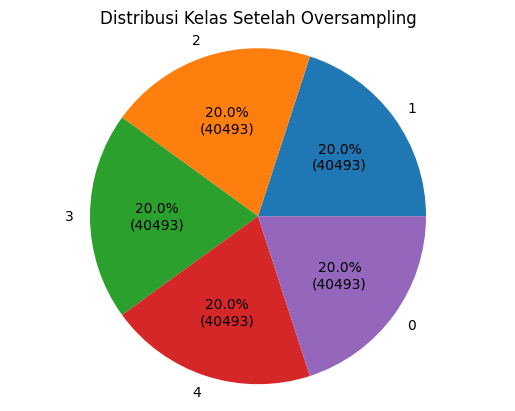

In [39]:
# Calculating Class Distribution After Resampling
counter = Counter(y_train_ros)
labels, values = zip(*counter.items())

# Pie chart
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p,(p/100)*sum(values)))
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribusi Kelas Setelah Oversampling')
plt.show()

### Undersampling

In [40]:
# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply undersampling to the training data
X_train_rus, y_train_rus = rus.fit_resample(X_train_vectorized, y_train)

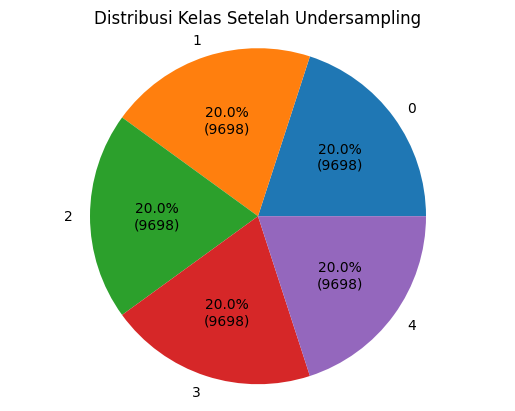

In [41]:
# Calculating Class Distribution After Resampling
counter = Counter(y_train_rus)
labels, values = zip(*counter.items())

# Pie chart
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p,(p/100)*sum(values)))
ax.axis('equal')

plt.title('Distribusi Kelas Setelah Undersampling')
plt.show()

## Label Encoding
---

> Example:<br>
Label Num 0 ▶ [1,0,0,0,0]<br>
Lbael Num 4 ▶ [0,0,0,0,1]

In [42]:
y_train_ohe = to_categorical(y_train)
y_train_ros_ohe = to_categorical(y_train_ros)
y_train_rus_ohe = to_categorical(y_train_rus)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

# 🤖 Modeling

## 📊Ploot Model History
---

Creating a function to view the visualization results of the model training in the form of graphs that show **the comparison results of training and validation data during the model training** from various evaluation parameters, namely `Accuracy, Loss, Precision, Recall, and AUC`.

In [43]:
def plot_hist(model_hist):
  model_hist_df = pd.DataFrame(model_hist.history)

  plt.figure(figsize=(20, 10))

  # Accuracy vs Val-Accuracy
  plt.subplot(2, 3, 1)
  sns.lineplot(data=model_hist_df[['accuracy', 'val_accuracy']])
  plt.grid()
  plt.title('Accuracy vs Val-Accuracy')

  # Loss vs Val-Loss
  plt.subplot(2, 3, 2)
  sns.lineplot(data=model_hist_df[['loss', 'val_loss']])
  plt.grid()
  plt.title('Loss vs Val-Loss')

  # Precision vs Val-Precision
  plt.subplot(2, 3, 3)
  sns.lineplot(data=model_hist_df[['precision', 'val_precision']])
  plt.grid()
  plt.title('Precision vs Val-Precision')

  # Recall vs Val-Recall
  plt.subplot(2, 3, 4)
  sns.lineplot(data=model_hist_df[['recall', 'val_recall']])
  plt.grid()
  plt.title('Recall vs Val-Recall')

  # AUC vs Val-AUC
  plt.subplot(2, 3, 5)
  sns.lineplot(data=model_hist_df[['auc', 'val_auc']])
  plt.grid()
  plt.title('AUC vs Val-AUC')

  plt.tight_layout()
  plt.show()

## 🧠 Function Evaluate Model
---

Creating a function to assist in the model testing process and to view it across various evaluation parameters starting from **Accuracy**, **Precision**, **Recall**, **F1-Score**, and **Confusion Matrix**.

In [44]:
def predict_model(X, y_true, model, class_labels):
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

## LSTM Model
---

The LSTM model is used as one of the NLP models to be evaluated as a Complaints Message Classification Model with an RNN model architecture consisting of several layers, including:
- **Embedding** ▶ Converts text input from integer tokens into dense, trained vectors. Each word is represented by a vector of a certain dimension.
- **LSTM** ▶ Two LSTM layers are used to learn long-term dependencies between words in the text. LSTM is capable of remembering information for a long period, which is very useful in natural language processing.
- **BatchNormalization** ▶ Used to stabilize and accelerate the training process by normalizing the input layer.
- **Relu** ▶ A nonlinear activation function used after batch normalization to add complexity to the model.
- **Dropout** ▶ Prevents overfitting by randomly setting the output features of the previous layer to zero during training.
- **Output Categorial** ▶ The output layer with softmax activation to classify inputs into different categories based on probability.

These layers are used to train the model, which consists of 25 epochs. There is also an early stopping callback process to halt training if the loss results on validation do not improve in the last 3 epochs; and a learning rate callback process to prevent the training model from being too biased towards the training data.

After the training process is completed using a function for model testing, the model testing process is carried out, and the evaluation results are reviewed.

In [2]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model
model = Sequential()
model.add(Embedding(input_dim=2650, output_dim=128))
model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.1))
model.add(LSTM(32))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC(curve='ROC')])
# Info Model Layer
print(model.summary())




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         339200    
                                                                 
 lstm (LSTM)                 (None, None, 64)          49408     
                                                                 
 batch_normalization (Batch  (None, None, 64)          256       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, None, 32)          2080      
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                     

### Train Model
Based on the model training conducted, the results show that the model achieved an accuracy of about 88% for the training model, with visualization results indicating no model bias during the training process.
> If a **higher percentage value is desired, it can be achieved by removing the early stopping used**. However, this could lead to model bias due to excessive training

In [46]:
# Learning Rate Decay Function
def lr_decay(epoch, lr):
    if epoch % 10 == 0 and epoch:
        return lr * 0.9
    return lr

# Early Stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Learning Rate Scheduler
lr_scheduler = LearningRateScheduler(lr_decay, verbose=1)

# Model Training
model_hist = model.fit(X_train_ros,
                       y_train_ros_ohe,
                       validation_data=(X_val_vectorized, y_val_ohe),
                       epochs=25,
                       callbacks=[lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
6328/6328 ━━━━━━━━━━━━━━━━━━━━ 206s 31ms/step - accuracy: 0.2098 - auc: 0.5142 - loss: 1.6145 - precision: 0.3792 - recall: 0.0035 - val_accuracy: 0.4463 - val_auc: 0.7849 - val_loss: 1.2615 - val_precision: 0.8684 - val_recall: 0.2844 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/25
6328/6328 ━━━━━━━━━━━━━━━━━━━━ 201s 32ms/step - accuracy: 0.4382 - auc: 0.7830 - loss: 1.2320 - precision: 0.8077 - recall: 0.1781 - val_accuracy: 0.7351 - val_auc: 0.9176 - val_loss: 0.8195 - val_precision: 0.8147 - val_recall: 0.5843 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/25
6328/6328 ━━━━━━━━━━━━━━━━━━━━ 200s 32ms/step - accuracy: 0.5380 - auc: 0.8418 - loss: 1.0830 - precision: 0.7936 - recall: 0.3272 - val_accuracy: 0.7972 - val_auc: 0.9523 - val_loss: 0.6111 - val_precision:

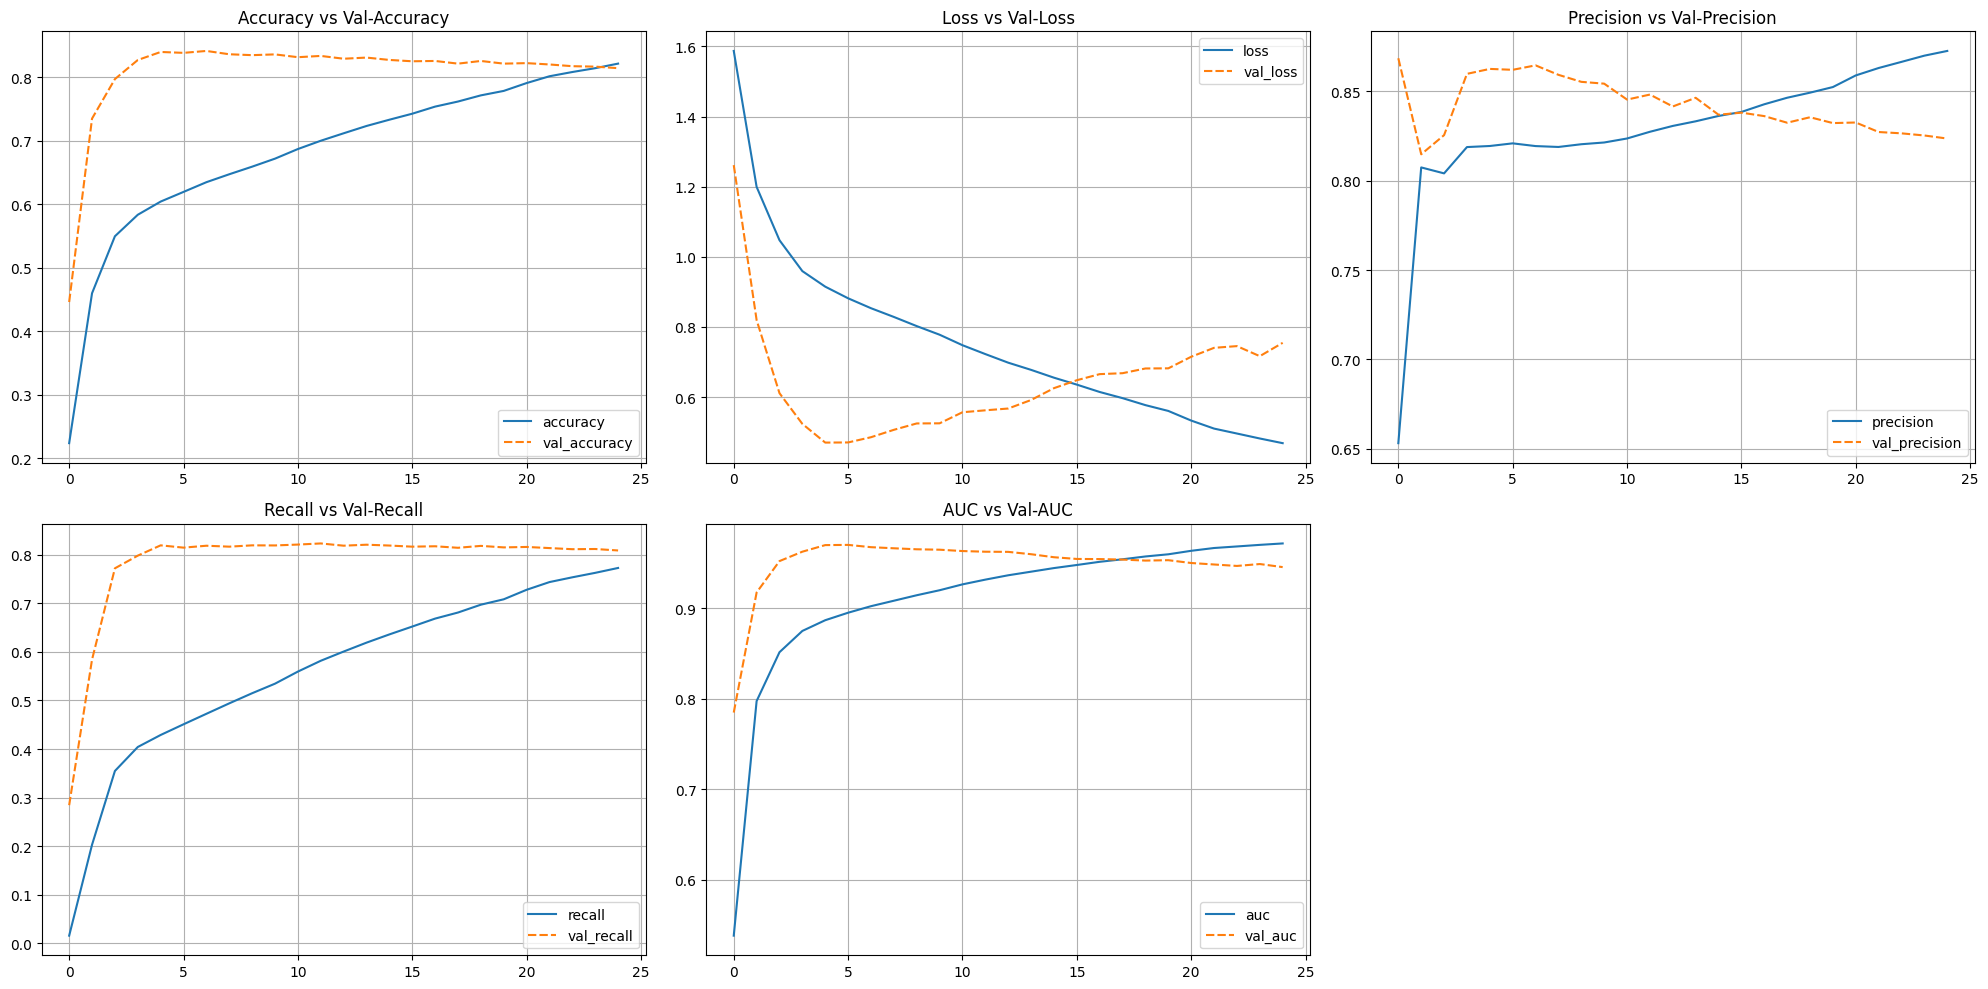

In [47]:
plot_hist(model_hist)

### Evaluate Model
The testing process using the trained model shows quite good results with a value of about 80% for all evaluations conducted.

778/778 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step
Accuracy: 0.8223739706768427
Precision: 0.8239486428517045
Recall: 0.8223739706768427
F1 Score: 0.8229539636050587


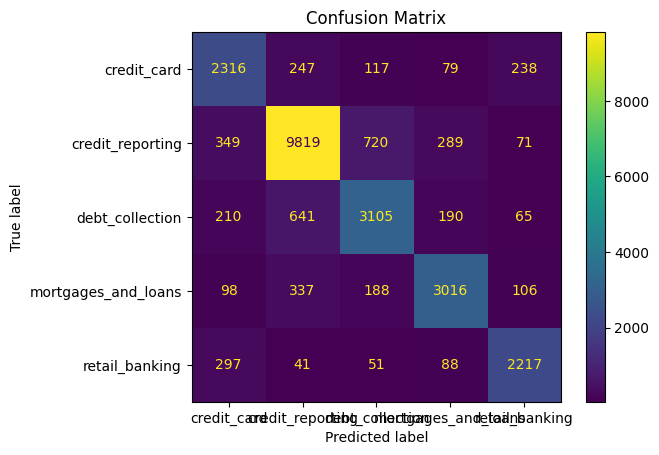

In [48]:
predict_model(X_test_vectorized,y_test_ohe,model,['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking'])

### Save Model

In [49]:
# Menyimpan Model
model.save('model_lstm_ros.h5')

# Menyimpan vectorizer
import pickle
pickle.dump({
    'config': vectorizer.get_config(),
    'weights': vectorizer.get_weights()},
            open("vectorizer_ros.pkl", "wb"))